In [1]:
import pandas as pd
import seaborn as sb
import joblib
import matplotlib.pyplot as plt
import truvari
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [55]:
def make_plot(rtg_fn, bench_fn, refine_q_fn, refine_t_fn, out_name, extra=""): 
    rtg = joblib.load(rtg_fn)
    view = rtg[rtg['svlen'] >= 5]
    parts = []
    for sz, dat in view.groupby('szbin'):
        if sz in ["SNP", "[1,5)", "[1k,2.5k)", "[2.5k,5k)", ">=5k"]:
            continue
        m = dat['state'].value_counts() 
        tbase = m['tp-base'] if 'tp-base' in m else 0
        tp = m['tp'] if 'tp' in m else 0
        fn = m['fn'] if 'fn' in m else 0
        fp = m['fp'] if 'fp' in m else 0
        m['precision'], m['recall'], m['f1'] = truvari.performance_metrics(tbase, tp, fn, fp)
        m['size'] = sz
        parts.append(m)
    rtg_summary = pd.concat(parts, axis=1).T.reset_index(drop=True)
    rtg_summary['program'] = 'vcfeval'
    
    # load bench
    truv = joblib.load(bench_fn)
    parts = []
    for sz, dat in truv.groupby('szbin'):
        if sz in ["SNP", "[1,5)"]:
            continue
        m = dat['state'].value_counts()
        tbase = m['tpbase'] if 'tpbase' in m else 0
        tp = m['tp'] if 'tp' in m else 0
        fn = m['fn'] if 'fn' in m else 0
        fp = m['fp'] if 'fp' in m else 0
        m['precision'], m['recall'], m['f1'] = truvari.performance_metrics(tbase, tp, fn, fp)
        m['size'] = sz
        parts.append(m)
    tru_bench_summary = pd.concat(parts, axis=1).T.reset_index(drop=True)
    tru_bench_summary['program'] = 'bench'
    
    # load refine
    d1 = joblib.load(refine_q_fn).rename(columns={"syndip_BD":"state"})
    d1['state'] = d1['state'].map({'TP':"tpbase", 'FP':'fp'})
    d2 = joblib.load(refine_t_fn).rename(columns={"HG002_BD":"state"})
    d2['state'] = d2['state'].map({'TP':"tp", 'FN':'fn'})
    refine = pd.concat([d1, d2])
    parts = []
    for sz, dat in refine.groupby('szbin'):
        if sz in ["SNP", "[1,5)"]:
            continue
        m = dat['state'].value_counts()
        tbase = m['tpbase'] if 'tpbase' in m else 0
        tp = m['tp'] if 'tp' in m else 0
        fn = m['fn'] if 'fn' in m else 0
        fp = m['fp'] if 'fp' in m else 0
        m['precision'], m['recall'], m['f1'] = truvari.performance_metrics(tbase, tp, fn, fp)
        m['size'] = sz
        parts.append(m)
    tru_refine_summary = pd.concat(parts, axis=1).T.reset_index(drop=True)
    tru_refine_summary['program'] = 'refine'
    
    all_summary = pd.concat([rtg_summary, tru_bench_summary, tru_refine_summary])
    
    view = all_summary.melt(id_vars=['program', 'size'], value_vars=['precision', 'recall', 'f1'])

    p = sb.lineplot(data=view[view['variable'] != 'f1'], x="size", y="value", hue="program", style="variable")
    sb.move_legend(p, "upper left", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45, ha='right')
    p.set(title="Alignment replicate variant performance" + extra, xlabel="Size Bin", ylabel="Value", ylim=(0, 1.01))
    plt.grid()  #just add this
    p.set_axisbelow(True)
    plt.tight_layout()
    plt.savefig(out_name)
    return rtg, truv, refine

In [57]:
full = make_plot("data/rtg_full.jl", 
                 "data/bench_full.jl", 
                 "data/refine_full_q.jl", 
                 "data/refine_full_t.jl", 
                 "Figure3full.pdf")
plt.close()

tier1 = make_plot("data/rtg_tier1.jl", 
                 "data/bench_tier1.jl", 
                 "data/refine_tier1_q.jl", 
                 "data/refine_tier1_t.jl", 
                 "Figure3_tier1.pdf",
                 " (Tier1)")
plt.close()

tier2 = make_plot("data/rtg_tier2.jl", 
                 "data/bench_tier2.jl", 
                 "data/refine_tier2_q.jl", 
                 "data/refine_tier2_t.jl", 
                 "Figure3_tier2.pdf",
                 " (Tier2)")
plt.close()

In [60]:
dat = tier1[0]
m = dat['state'].value_counts()
tbase = m['tp-base'] if 'tp-base' in m else 0
tp = m['tp'] if 'tp' in m else 0
fn = m['fn'] if 'fn' in m else 0
fp = m['fp'] if 'fp' in m else 0
print('rtg', truvari.performance_metrics(tbase, tp, fn, fp))

dat = tier1[2]
m = dat['state'].value_counts()
tbase = m['tpbase'] if 'tpbase' in m else 0
tp = m['tp'] if 'tp' in m else 0
fn = m['fn'] if 'fn' in m else 0
fp = m['fp'] if 'fp' in m else 0
print('refine', truvari.performance_metrics(tbase, tp, fn, fp))

rtg (0.9201635080611207, 0.8044814965143521, 0.858442768267111)
refine (0.9999581309663373, 0.9999860272747597, 0.999972078925992)


In [ ]:
d1 = joblib.load("data/refine_tier1_q.jl").rename(columns={"syndip_BD":"state"})
d1['state'] = d1['state'].map({'TP':"tpbase", 'FP':'fp'})
d2 = joblib.load(refine_t_fn).rename(columns={"HG002_BD":"state"})
d2['state'] = d2['state'].map({'TP':"tp", 'FN':'fn'})
refine = pd.concat([d1, d2])

In [16]:

counts = view['state'].value_counts()
counts

tp         124902
tp-base    118173
fp          28437
fn          18612
Name: state, dtype: int64

In [17]:
prec, recall, f1 = truvari.performance_metrics(counts['tp-base'], counts['tp'], counts['fn'], counts['fp'])
print(prec, recall, f1)

0.8145481580028564 0.8639324487334138 0.8385138105623284


In [18]:
counts['tp'] + counts['fp']

153339

In [19]:
view['state'].value_counts()

tp         124902
tp-base    118173
fp          28437
fn          18612
Name: state, dtype: int64

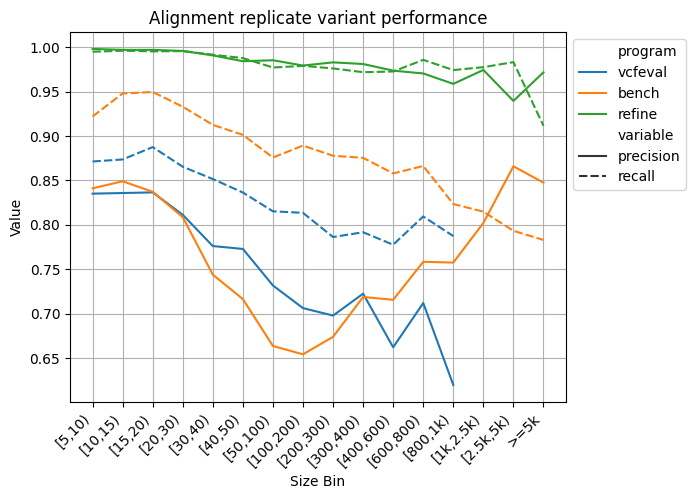